In [6]:
#%pip install tensorflow
import numpy as np
import random
import json
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#nltk.download('punkt')
#nltk.download('wordnet')


In [25]:
# Load the dataset
lemmatizer = WordNetLemmatizer()
# Use a raw string to avoid unicode escape issues
intents = json.loads(open(r'C:\Users\ayush\Downloads\chat4.json').read())

words = []
classes = []
documents = []
ignore_words = ['?', '!', '.', ',']

# Tokenize and lemmatize
for intent in intents['intents']:
    for pattern in intent['patterns']:
        word_list = nltk.word_tokenize(pattern)
        words.extend(word_list)
        documents.append((word_list, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(set(words))
classes = sorted(set(classes))

# Preparing training data
training = []
output_empty = [0] * len(classes)

for doc in documents:
    bag = []
    word_patterns = doc[0]
    word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

random.shuffle(training)
training = np.array(training, dtype=object)
train_x = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

In [28]:
# Building the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD

# Building the model
model = Sequential()
model.add(Input(shape=(len(train_x[0]),)))  # Use Input layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train the model
history=model.fit(train_x, train_y, epochs=200, batch_size=8, verbose=1)

# Save the model
model.save('my_model.keras')



Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0587 - loss: 3.2805      
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0271 - loss: 3.2419     
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0884 - loss: 3.1751     
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0598 - loss: 3.1303 
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1276 - loss: 3.0538 
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1360 - loss: 3.0508 
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2205 - loss: 2.8758 
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2010 - loss: 2.8738 
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1606 - loss: 2.7982 
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1460 - loss: 2.8405 
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1611 - loss: 2.7888 
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━━

In [30]:
average_accuracy = np.mean(history.history['accuracy'])
print(f"Average accuracy over 200 epochs: {average_accuracy:.4f}")

Average accuracy over 200 epochs: 0.7551


KeyError: 'val_accuracy'

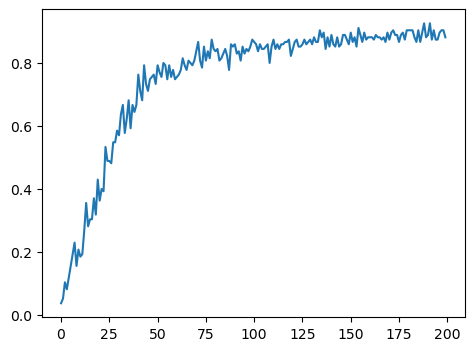

In [32]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [34]:
# Load the model and necessary data
from tensorflow.keras.models import load_model

model = load_model('my_model.keras')
intents = json.loads(open(r'C:\Users\ayush\Downloads\intents.json').read())

def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

def bow(sentence, words, show_details=True):
    sentence_words = clean_up_sentence(sentence)
    bag = [0]*len(words)
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s:
                bag[i] = 1
                if show_details:
                    print(f"found in bag: {w}")
    return(np.array(bag))

def predict_class(sentence, model):
    p = bow(sentence, words, show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

def get_response(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if i['tag'] == tag:
            result = random.choice(i['responses'])
            break
    return result

def chatbot_response(msg):
    ints = predict_class(msg, model)
    res = get_response(ints, intents)
    return res


In [36]:
# Start chatting with the chatbot
while True:
    message = input("You: ")
    if message.lower() == "quit":
        break
    response = chatbot_response(message)
    print(f"Bot: {response}")


You:  hello


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


IndexError: list index out of range

In [ ]:
pip install flask tensorflow nltk


In [30]:
from flask import Flask, request, jsonify
import numpy as np
import nltk
import json
import random
import pickle
from tensorflow.keras.models import load_model

# Initialize the Flask app
app = Flask(__name__)

# Load the trained model, intents, and the necessary files
model = load_model(r'C:\Users\ayush\my_model.keras')
intents = json.loads(open(r'C:\Users\ayush\Downloads\intents.json').read())
words = pickle.load(open(r'C:\Users\ayush\Documents\ML\words.pkl', 'rb'))
classes = pickle.load(open(r'C:\Users\ayush\Documents\ML\classes.pkl', 'rb'))

# Preprocess the input sentence
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [nltk.stem.WordNetLemmatizer().lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

# Convert a sentence into a bag of words
def bow(sentence, words, show_details=True):
    sentence_words = clean_up_sentence(sentence)
    bag = [0]*len(words)  
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s: 
                bag[i] = 1
    return(np.array(bag))

# Predict the intent
def predict_class(sentence, model):
    p = bow(sentence, words)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]

    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

# Get a response based on the predicted intent
def get_response(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if i['tag'] == tag:
            result = random.choice(i['responses'])
            break
    return result

@app.route('/chat', methods=['POST'])
def chat():
    message = request.json.get("message")
    ints = predict_class(message, model)
    response = get_response(ints, intents)
    return jsonify({"response": response})

if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\ayush\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
%tb